<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Use-gurobi-with-guesses-about-AR" data-toc-modified-id="Use-gurobi-with-guesses-about-AR-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Use gurobi with guesses about AR</a></span><ul class="toc-item"><li><span><a href="#Helper-classes-and-functions" data-toc-modified-id="Helper-classes-and-functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Helper classes and functions</a></span></li></ul></li><li><span><a href="#Classical-times" data-toc-modified-id="Classical-times-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classical times</a></span><ul class="toc-item"><li><span><a href="#Match-time" data-toc-modified-id="Match-time-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match time</a></span></li><li><span><a href="#Optimal-time" data-toc-modified-id="Optimal-time-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Optimal time</a></span></li></ul></li><li><span><a href="#Gurobi-modeling" data-toc-modified-id="Gurobi-modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gurobi modeling</a></span></li><li><span><a href="#Gurobi-upper-and-lower-bounds-for-AR" data-toc-modified-id="Gurobi-upper-and-lower-bounds-for-AR-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Gurobi upper and lower bounds for AR</a></span><ul class="toc-item"><li><span><a href="#Gurobi-activate" data-toc-modified-id="Gurobi-activate-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Gurobi activate</a></span></li></ul></li></ul></div>

In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt

from cartesian_explorer import Explorer
import cartesian_explorer as caex

import qtensor
import pickle
import socket

In [11]:
cache = caex.caches.JobLibCache("../caex_cache/energy_eff")
if socket.gethostname().startswith('skylake'):
    print('Using ray parallel for caex')
    parallel = caex.parallels.Ray(processes=55)
else:
    parallel = None
    parallel = caex.parallels.Ray(processes=2)
ex = Explorer(cache=cache, parallel=parallel)

2021-11-23 21:04:18,053	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


Using ray parallel for caex


## Use gurobi with guesses about AR




* $UB$ - upper bound on maxcut cost
* $LB$ - lower bound 
* $C$ - optimal cost
$UB>C$


$AR = \frac{LB}{C} > \frac{LB}{UB}$

In [12]:
#%load_ext autoreload
#%autoreload 2

In [13]:
import miplog_helper, scale_helper

In [14]:
import xarray as xar

### Helper classes and functions

In [15]:

from datetime import datetime, timedelta
from functools import wraps

class throttle():
    """ Decorator class that limits number of calls for function"""
    def __init__(self, per_sec=20, max_calls=1, warmup=0):
        self.period = timedelta(microseconds=1000000/per_sec)
        self.t0 = datetime.min
        self.max_calls = max_calls
        self.calls_done = 0
        self.warmup = timedelta(seconds=warmup)
        self.warmup_expired = False

    def __call__(self, fn):
        @wraps(fn)
        def wrapper(*args, **kwargs):
            t1 = datetime.now()
            if self.t0 == datetime.min:
                self.t0 = t1
            dt = t1 - self.t0
            secs2wait = (self.period - dt).total_seconds()
            if self.warmup_expired:
                if secs2wait > 0:
                    if self.calls_done==self.max_calls:
                        return 
                    else:
                        self.calls_done += 1
                else:
                    self.calls_done = 1
                    self.t0 = datetime.now()
            else:
                self.warmup_expired = self.warmup < dt

            return fn(*args, **kwargs)

        return wrapper 

In [16]:
import networkx as nx
from typing import Tuple
import gurobipy as gb
import time

def maxcut_bounds_history(G: nx.Graph,
                          max_time=10*60,
                          max_cost=None,
                          threads=None,
                          timedelta=3,
                          max_ar=1.0,
                          verbose=True,
                          callback=None,
                          gurobi_options={}
                         ) -> Tuple[list, list]:
    p = gb.Model()
    p.setParam('TimeLimit', max_time)
    if max_cost is not None:
        p.setParam('BestObjStop', max_cost)
    if threads is not None:
        p.setParam('Threads', threads)
    if verbose is False:
        p.setParam('OutputFlag', 0)
    for key in gurobi_options:
        p.setParam(key, gurobi_options[key])
        
    vdict = {}
    for n in G.nodes:
        vdict[n] = p.addVar(name='v_'+str(n), vtype=gb.GRB.BINARY)
    scaled_v = {v:(2*x - 1) for v, x in vdict.items()}
    C_i = [vdict[i] + vdict[j] - 2*vdict[i]*vdict[j] for i, j in G.edges]
    
    p.setObjective(sum(C_i), gb.GRB.MAXIMIZE)
    
    startop = time.time()
    upper = []
    lower = []
    def clb(model, where):
        # See here https://www.gurobi.com/documentation/9.1/refman/cb_codes.html
        return None
        
    miplog = []
    start = time.time()

    @throttle(per_sec=1, warmup=1)
    @throttle(per_sec=100)
    def on_update(model, where, cost, bound):
        nonlocal start
        if start == 0:
            start = time.time()
        dt = time.time()-start
        miplog.append([dt, bound, cost])
        print(f'[{dt}]', 'MIP', 'cost=', cost, 'bound=', bound)

    def clb(model, where):
        # See here https://www.gurobi.com/documentation/9.1/refman/cb_codes.html
        if where == gb.CallbackClass.MIP:
            cst = model.cbGet(gb.CallbackClass.MIP_OBJBST)
            bnd = model.cbGet(gb.CallbackClass.MIP_OBJBND)
            on_update(model, where, cst, bnd)
        if where == gb.CallbackClass.MIPSOL:
            cst = model.cbGet(gb.CallbackClass.MIPSOL_OBJBST)
            bnd = model.cbGet(gb.CallbackClass.MIPSOL_OBJBND)
            on_update(model, where, cst, bnd)
        
    if callback is None:
        callback = clb
        
    p.optimize(callback=callback)
    miplog.append(
        [time.time()-startop, p.ObjBound, p.ObjVal]
    )
        
    return miplog



Set gurobi thread count to 1, so it's more meaningful to compare between different machines and more correct when doing parallel calculations

In [17]:
GUROBI_THREADS = 1 #set to 0 to use all available

## Classical times

In [18]:
@ex.provider
def graph(N, seed=10, degree=3):
    return qtensor.toolbox.random_graph(nodes=N, seed=seed, degree=degree)

@ex.add_function(provides=('classical_time_gurobi', 'opt_cost'), requires=('graph', ))
def classical_time_gurobi(graph):
    start = time.time()
    c, sol = qtensor.tools.maxcut.gurobi_maxcut(graph, max_time=15*60, threads=GUROBI_THREADS)
    return time.time() - start, c
    
@ex.provider
def gurobi_hist(graph, max_time=600, gurobi_options={}):
    miplog = maxcut_bounds_history(
        graph, max_time=max_time, threads=GUROBI_THREADS,
        gurobi_options=gurobi_options
    )
    dh = miplog_helper.MiplogData(miplog)
    diffs = dh.get_diff_data()
    start = dh.get_starting_point()
    return [start] + diffs

@ex.provider
def classical_time_gw(graph):
    start = time.time()
    c = qtensor.tools.maxcut.goemans_williamson.gw_cost(graph)
    return time.time() - start
    

In [19]:
g = ex.get_variable('graph', N=10, seed=10, degree=4)
dict(g.degree())

{3: 4, 7: 4, 4: 4, 6: 4, 1: 4, 0: 4, 8: 4, 2: 4, 5: 4, 9: 4}

### Match time

In [27]:
match_ext = np.concatenate([
    np.linspace(30, 100, 3),
    np.linspace(150, 1000, 3),
    np.linspace(1400, 5000, 2),
    np.linspace(5200, 12400, 4),
    np.linspace(15000, 40000, 3),
    np.linspace(50000, 100000, 3),
])
match_ext = [2*int(x/2) for x in match_ext]
print(match_ext)
len(match_ext)*100/55*5/60

[30, 64, 100, 150, 574, 1000, 1400, 5000, 5200, 7600, 10000, 12400, 15000, 27500, 40000, 50000, 75000, 100000]


2.727272727272727

In [28]:
seeds = range(10, 110)
degree=3
options_preset_map = {
    'symLin2': {'Symmetry': 0, 'PreQLinearize': 2}
   , 'symLin1': {'Symmetry': 0, 'PreQLinearize': 1}
   , 'symLin0': {'Symmetry': 0, 'PreQLinearize': 0}
   , 'default': {}
}
options_preset = 'symLin2'
# symLin2 is a good one, used for most previous (2021 July 2nd half) runs
options = options_preset_map[options_preset]
print('Using gurobi options', options)

gurobi_bytes = ex.map_variable(('gurobi_hist')
                               , N=match_ext
                               , seed=seeds
                               , max_time=[5*60]
                               , degree=[degree]
                               , gurobi_options=[options]
                 )

xd = xar.DataArray(gurobi_bytes, dims=('N', 'seed'), coords=(match_ext, seeds))
# save the data
pickle.dump(xd, open(f'../gurobi_match_d{degree}_gp{options_preset}.pkl', 'wb'))

Using gurobi options {'Symmetry': 0, 'PreQLinearize': 2}


/home/dlykov/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


[0.8878264427185059, 18600.0, 16483.0]

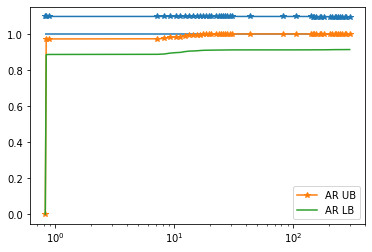

In [112]:
dat = gurobi_bytes[-7][1]

mh = miplog_helper.MiplogData.from_start_and_diffs(dat[0], dat[1:])
mh.plot()
mh.miplog[4]

In [30]:
xd = xar.DataArray(gurobi_bytes, dims=('N', 'seed'), coords=(match_ext, seeds))
xd

<xarray.DataArray (N: 18, seed: 100)>
array([[list([(0.0016052722930908203, 90.0, -0.0), (1, 0.009133338928222656, 48.0), (2, 1, 39.0), (1, 0.01027369499206543, 1.0), (1, 0.00573420524597168, 2.0)]),
        list([(0.0016260147094726562, 90.0, -0.0), (1, 0.011939764022827148, 48.0), (2, 1, 40.0), (1, 0.0069577693939208984, 2.0)]),
        list([(0.0018780231475830078, 90.0, -0.0), (1, 0.0043108463287353516, 49.0), (2, 1, 41.0)]),
        ...,
        list([(0.0012898445129394531, 90.0, -0.0), (1, 0.010724782943725586, 47.00000000000001), (2, 1, 39.0), (1, 0.010035991668701172, 0.9999999999999929), (1, 0.010027408599853516, 1.0), (1, 0.001842498779296875, 2.0)]),
        list([(0.0011916160583496094, 90.0, -0.0), (1, 0.015011072158813477, 48.0), (2, 1, 40.0), (1, 0.008001565933227539, 2.0)]),
        list([(0.0012671947479248047, 90.0, -0.0), (1, 0.009620904922485352, 46.00000000000001), (2, 1, 42.0), (1, 0.008039236068725586, 1.999999999999993)])],
       [list([(0.0015239715576171875, 192.0, -0.0), (1, 0.00903010368347168, 98.0), (2, 1, 83.0), (2, 0.04220700263977051, 2.0), (1, 0.011115550994873047, 1.0), (2, 1, 3.0), (1, 0.010871648788452148, 1.0), (1, 0.02107691764831543, 1.0), (1, 0.03200554847717285, 1.0), (1, 0.01058816909790039, 2.0)]),
        list([(0.0015950202941894531, 192.0, -0.0), (1, 0.008929252624511719, 99.0), (2, 1, 85.0), (1, 0.011441230773925781, 1.0), (1, 0.04533696174621582, 1.0), (2, 1, 1.0), (1, 0.04099130630493164, 1.0), (1, 0.0309755802154541, 1.0), (1, 0.020908117294311523, 1.0), (1, 0.012838125228881836, 2.0)]),
        list([(0.001613616943359375, 192.0, -0.0), (1, 0.008885622024536133, 99.0), (2, 1, 86.0), (1, 0.019083499908447266, 1.0), (1, 0.020769357681274414, 1.0), (2, 1, 2.0), (1, 0.010118484497070312, 1.0), (1, 0.008892536163330078, 2.0)]),
        ...,
        list([(0.0015692710876464844, 192.0, -0.0), (1, 0.009016275405883789, 98.0), (2, 1, 86.0), (1, 0.02787041664123535, 1.0), (1, 0.024776458740234375, 1.0), (2, 0.021352052688598633, 1.0), (1, 0.010138511657714844, 1.0), (1, 0.030500411987304688, 1.0), (1, 0.0303041934967041, 1.0), (1, 0.014657258987426758, 2.0)]),
        list([(0.0016155242919921875, 192.0, -0.0), (1, 0.009670734405517578, 98.0), (2, 1, 87.0), (1, 0.010699987411499023, 1.0), (1, 0.03844332695007324, 1.0), (2, 0.010053634643554688, 2.0), (1, 0.0074002742767333984, 3.0)]),
        list([(0.0023441314697265625, 192.0, -0.0), (1, 0.008148670196533203, 98.0), (2, 1, 86.0), (1, 0.011661767959594727, 2.0), (1, 0.021262168884277344, 1.0), (1, 0.022850513458251953, 1.0), (2, 1, 1.0), (1, 0.010380268096923828, 1.0), (1, 0.0028417110443115234, 2.0)])],
       [list([(0.001947164535522461, 300.0, -0.0), (1, 0.008913993835449219, 153.0), (2, 1, 133.0), (1, 0.010154485702514648, 3.0), (2, 0.01745152473449707, 2.0), (2, 0.056909799575805664, 1.0), (1, 0.021114110946655273, 1.0), (2, 1, 1.0), (1, 0.0566563606262207, 1.0), (1, 0.08354973793029785, 1.0), (1, 0.13770246505737305, 1.0), (1, 0.1165618896484375, 1.0), (1, 0.07303881645202637, 2.0)]),
        list([(0.0018186569213867188, 300.0, -0.0), (1, 0.00896596908569336, 153.0), (2, 1, 134.0), (1, 0.010528087615966797, 2.0), (1, 0.014715909957885742, 1.0), (2, 0.011034488677978516, 2.0), (2, 0.010111808776855469, 1.0), (1, 0.03177905082702637, 2.842170943040401e-14), (1, 0.031517744064331055, 0.9999999999999716), (1, 0.08753657341003418, 1.0), (1, 0.022977352142333984, 1.0), (1, 0.0647733211517334, 1.0), (1, 0.045485734939575195, 1.0), (1, 0.02756023406982422, 2.0)]),
        list([(0.0018224716186523438, 300.0, -0.0), (1, 0.008562564849853516, 155.0), (2, 1, 129.0), (1, 0.012145519256591797, 2.0), (2, 0.010236740112304688, 3.0), (1, 0.010308265686035156, 1.0), (2, 0.10415983200073242, 1.0), (1, 0.05206871032714844, 1.0), (1, 0.17774415016174316, 1.0), (1, 0.0736851692199707, 1.0), (2, 0.14461517333984375, 2.0), (1, 0.07612752914428711, 1.0), (1, 0.1094369888305664, 1.0), (1, 0.08680081367492676, 1.0), (1, 0.014970779418945312, 1.0)]),

In [31]:
def to_mh(item):
    starts, *diffs = item
    return miplog_helper.MiplogData.from_start_and_diffs(starts, diffs)

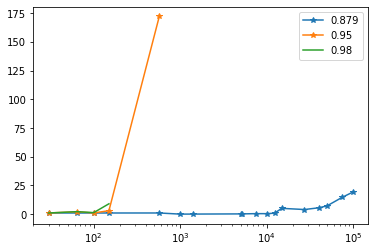

In [32]:
# check data
seed = 1

line = [to_mh(x).get_time_for_AR_lower(0.849)[0] for x in gurobi_bytes[:, seed]]
plt.plot(match_ext, line, '*-', label='0.879')
plt.xscale('log')
plt.legend()
line = [to_mh(x).get_time_for_AR_lower(0.95)[0] for x in gurobi_bytes[:, seed]]
plt.plot(match_ext, line, '*-', label='0.95')

line = [to_mh(x).get_time_for_AR_lower(0.98)[0] for x in gurobi_bytes[:, seed]]
plt.plot(match_ext, line, label='0.98')
plt.legend()

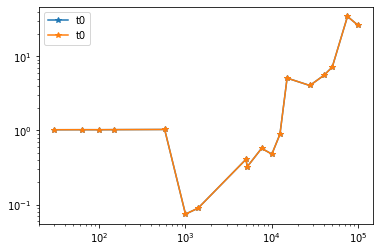

In [84]:
# check data t0
seed = 1
def get_t0(x):
    mh = to_mh(x)
    return mh.miplog[4][0]
    for t, b, c in mh.miplog:
        if c>0:
            return t

line = [get_t0(x) for x in gurobi_bytes[:, seed]]
plt.plot(match_ext, line, '*-', label='t0')
plt.loglog()
plt.plot(match_ext, line, '*-', label='t0')

plt.legend()

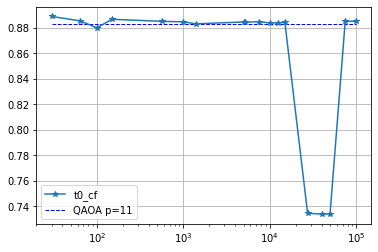

In [108]:
def get_t0_cf(x):
    mh = to_mh(x)
    for t, b, c in mh.miplog:
        if c>0:
            return c

line = xar.apply_ufunc(get_t0_cf, xd, vectorize=True).median('seed')
plt.plot(match_ext, np.array(line)/np.array(match_ext)/1.5, '*-', label='t0_cf')
plt.xscale('log')

plt.hlines(0.8828425408436951, min(match_ext), max(match_ext),
           label=f'QAOA p={11}', color='blue', linewidth=1, 
           linestyle='--'
          )
plt.legend()
plt.grid()

In [67]:
line


<xarray.DataArray (N: 18)>
array([4.00000e+01, 8.50000e+01, 1.32000e+02, 1.99500e+02, 7.62000e+02,
       1.32700e+03, 1.85450e+03, 6.63400e+03, 6.89750e+03, 1.00870e+04,
       1.32565e+04, 1.64380e+04, 1.98980e+04, 3.02955e+04, 4.40235e+04,
       5.50395e+04, 9.95830e+04, 1.32754e+05])
Coordinates:
  * N        (N) int64 30 64 100 150 574 1000 ... 27500 40000 50000 75000 100000

### Optimal time

In [11]:
max_N = 3000
opt_max_N = 520
seeds = [10, 11, 12, 13, 14]

In [13]:
x_ext = np.array(range(10, max_N, 36))
x_opt = np.array(range(10, opt_max_N, 16))

opt_time = ex.map_variable(('classical_time_gurobi')
                           , N=x_opt
                           , seed=seeds
                 )


KeyboardInterrupt: 

In [15]:
opt = xar.DataArray(opt_time, dims=('N', 'seeds'), coords=(x_opt, seeds))

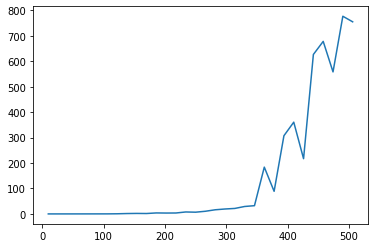

In [16]:
# check the data
plt.plot(x_opt, np.mean(opt_time, -1))

## Gurobi modeling

In [ ]:
import tqdm.auto as tqdm

import time

In [ ]:
SEEDS = range(1, 2)

In [ ]:
for seed in SEEDS:
    miplog3 = maxcut_bounds_history(nx.random_regular_graph(3, 390, seed=seed), max_time=200, )

In [ ]:
dh = miplog_helper.MiplogData(miplog3)
byt = dh.get_bytes()
dh2 = miplog_helper.MiplogData.from_bytes(byt)
miplog4 = dh2.miplog
miplog4

In [ ]:
mipd = np.array(miplog4).T

start = 2
opt = mipd[2][-1]
ix = np.argmin(np.abs(30-mipd[0]))
print('ix', ix, mipd[0][ix])
cost_lb = mipd[2][ix]
plt.plot(mipd[0][start:], mipd[1][start:]/opt, '*-')
plt.plot(mipd[0][start:], mipd[2][start:]/(opt), '*-', label='AR')
plt.plot(mipd[0][start:], mipd[2][start:]/cost_lb, '*-', label='AR UB')
plt.plot(mipd[0][start:], mipd[2][start:]/mipd[1][start:], '-', label='AR LB')
plt.legend()
plt.xscale('log')
plt.hlines(1, min(mipd[0][start:]), max(mipd[0]))

In [31]:
def get_time_for_AR_lower(miplog, AR):
    """ 
    Args:
        miplog (np.array): :,3 shaped array with times, upper bound cost and lower bound cost
        AR (float): which AR bound to look for
    Returns:
        time, AR
    """
    times, bounds, costs = np.array(miplog)[1:].T
    AR_bound = costs/bounds
    # get the index at which AR bound is higher than requested
    ix = np.where((AR_bound-AR)>0)[0]
    if len(ix)==0: return None, None
    else: ix = min(ix)
    return times[ix], AR_bound[ix]
    

In [32]:
get_time_for_AR_lower(miplog, 0.9)

NameError: name 'miplog' is not defined

In [33]:
def get_time_for_AR_upper(miplog, AR):
    """ 
    Args:
        miplog (np.array): :,3 shaped array with times, upper bound cost and lower bound cost
        AR (float): which AR bound to look for
    Returns:
        time, AR
    """
    times, bounds, costs = np.array(miplog)[1:].T
    AR_bound = costs/costs[-1]
    # get the index at which AR bound is higher than requested
    ix = np.where((AR_bound-AR)>=0)[0]
    if len(ix)==0: return None, None
    else: ix = min(ix)
    return times[ix], AR_bound[ix]
    

In [ ]:
get_time_for_AR_upper(miplog3, 0.999), get_time_for_AR_lower(miplog3, 0.996)

In [ ]:
get_time_for_AR_upper(miplog4, 0.999), get_time_for_AR_lower(miplog4, 0.996)

In [ ]:
times = [(get_time_for_AR_upper(miplog, x)[0],
         get_time_for_AR_lower(miplog, x)[0]) for x in np.linspace(0.85, 1, 20)]

In [ ]:
_t = np.array(times).T
plt.plot(np.linspace(0.85, 1, 20), _t[0], label='upper')
plt.plot(np.linspace(0.85, 1, 20), _t[1], label='lower')
plt.legend()
plt.ylabel('Time to achieve')
plt.xlabel('AR')
plt.yscale('log')

In [ ]:
plt.hist(np.log(dt), bins=50)

In [ ]:
plt.plot(mipd[0])

In [ ]:
i

In [ ]:
for upper, lower in zip(updata, ldata):
    plt.plot(upper, label='upper', alpha=0.3, color='r')
    plt.plot(lower, label='lower', alpha=0.3, color='b')
    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')

In [ ]:
for upper, lower in zip(updata, ldata):
    upper = np.array(upper)
    lower = np.array(lower)
    x = range(1, len(lower)+1)
    #plt.plot(upper/upper.min(), label='upper', alpha=0.3, color='r')
    plt.plot(x, lower/lower.max(), label='lower', alpha=0.3, color='b')
    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')

In [ ]:
for upper, lower in zip(updata, ldata):
    upper = np.array(upper)
    lower = np.array(lower)
    x = range(0, len(lower))
    #plt.plot(upper/upper.min(), label='upper', alpha=0.3, color='r')
    plt.plot(x, lower/lower.max(), label='lower', alpha=0.3, color='b')
plt.xscale('symlog')    
plt.xlabel('Time, seconds')
plt.ylabel('Cost value')
plt.grid()

## Gurobi upper and lower bounds for AR

$$$
\foreach \delta>0 AR(t+\delta)>AR(t)
$$$

### Gurobi activate

In [33]:
import socket

if socket.gethostname() == 'DESKTOP-1OG5J92':
    gurobi_lic = '/home/plate/git-built/gurobi/'
    print('getting license')
    grbkey = 'd3f381ce-d331-11eb-89be-0242ac120002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey
    
elif socket.gethostname().startswith('skylake'):
    gurobi_lic = '/home/danlkv/git-build/gurobi/'
    print('getting license')
    grbkey = '32956844-dfa0-11eb-8601-0242ac120002'
    # (over)write key to gurobi_lic directory and don't ask questions
    !grbgetkey -q --path $gurobi_lic $grbkey

getting license
info  : grbgetkey version 9.1.2, build v9.1.2rc0
info  : Contacting Gurobi license server...
error : ERROR 303: hostname jlselogin6.pub.jlse.anl.gov (140.221.96.148) not recognized as belonging to an academic domain
info  : Is your computer connected to the university network?
info  : Your computer must be connected to the university network for the grbgetkey
info  : command to work. You can connect your computer either directly or via a VPN
info  : that tunnels all traffic through the university network.  Once the license
info  : file is setup, your computer does not need to be connected to the university
info  : network. You can repeat this process to get licenses for additional computers.
info  : If you are unable to setup this license file, please visit our support website
info  : https://support.gurobi.com for further assistance.


In [10]:
socket.gethostname()

'skylake08'

In [11]:
qtensor.tools.maxcut.gurobi_maxcut(nx.random_regular_graph(3, 12))

Academic license - for non-commercial use only - registered to dlykov@anl.gov
Using license file /home/danlkv/git-build/gurobi/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID
Changed value of parameter TimeLimit to 600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 56 physical cores, 112 logical processors, using up to 32 threads
Academic license - for non-commercial use only - registered to dlykov@anl.gov
Optimize a model with 0 rows, 12 columns and 0 nonzeros
Model fingerprint: 0xf5cf4a2a
Model has 18 quadratic objective terms
Variable types: 0 continuous, 12 integer (12 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+00, 3e+00]
  QObjective range [4e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 18 rows, 30 columns, 54 nonze

(15.0, [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0])